In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# modeling libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Classification metric
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv("Airline Passenger Satisfaction.csv").set_index('id').drop(columns=['Unnamed: 0', 'satisfaction score'])
df['satisfaction'] = df['satisfaction'].apply(lambda x: 1 if x=='satisfied' else 0)
df = pd.get_dummies(df, columns=['Gender', 'Customer Type', 'Type of Travel', 'Class', ], dtype='int64')

# moving target column to start for easier referrencing
target = 'satisfaction'
column_to_move = df.pop(target)
df.insert(0, target, column_to_move)

In [3]:
df_shuffled = df.sample(frac=1)
train, test, val =  np.split(df_shuffled, [int(len(df_shuffled)*0.6), int(len(df_shuffled)*0.8)])

In [4]:
# function for scaling data to be fitted, with additional functionality of oversampling
def scale_data(data, oversample=False):
    x =  data[data.columns[1:]].values
    y = np.reshape(data[data.columns[0]].values, (-1,1))

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    if oversample:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(x,y)

    data = np.hstack((np.reshape(y, (-1, 1)), x))


    return data, x, y

# function for plotting changes in performance over time
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.legend()
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  ax2.grid(True)

  plt.show()

In [5]:
train, train_x, train_y = scale_data(data=train, oversample = False)
test, test_x, test_y = scale_data(data=test, oversample = False)
val, val_x, val_y = scale_data(data=val, oversample = False)

In [6]:
# building model
nnModel =  Sequential([
    Dense(64, activation = 'relu', input_shape =(train_x.shape[1], )),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

nnModel.compile(optimizer=Adam(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

In [17]:
nnModel.evaluate(val_x, val_y)

812/812 [==============================] - 2s 3ms/step - loss: 0.0972 - accuracy: 0.9590


[0.09723209589719772, 0.9590390920639038]

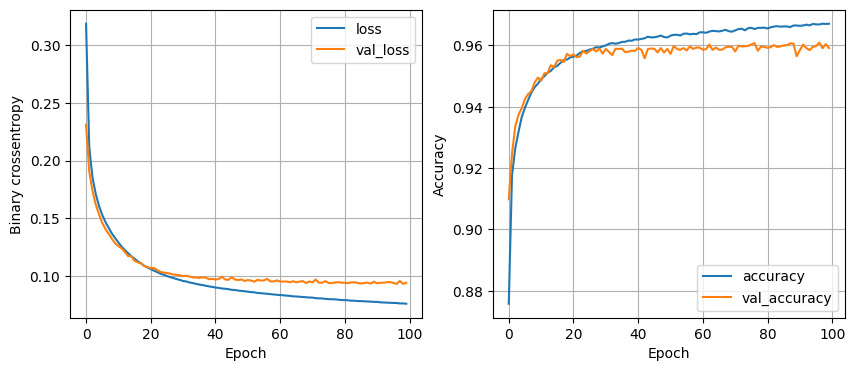

In [7]:
history = nnModel.fit(x=train_x, y=train_y, epochs = 100, batch_size = 32, validation_data = (val_x, val_y), verbose = 0)
plot_history(history)

In [9]:
pred_y = np.reshape(nnModel.predict(test_x), (-1, ))
pred_y = (pred_y >0.5).astype(int).reshape(-1,)
print(classification_report(test_y, pred_y))

812/812 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     14657
           1       0.96      0.94      0.95     11319

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976

